# CO2 source: CarbonTracker observation data, 182 stations, 2000-2017
# CO2 analysis method: NOAA

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from os import listdir
from os.path import isfile, join
import ccg_filter
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

font = {'weight' : 'bold', 'size' : 14}
matplotlib.rc('font', **font)

# Define functions 

In [2]:
def decimalDate_ymd (year, month, day=15):
    """ Convert a date to a fractional year. """
    pd_date = pd.to_datetime(year*10000 + month*100 + day, format='%Y%m%d')
    
    return pd_date.dt.year + pd_date.dt.dayofyear / [366 if x else 365 for x in pd_date.dt.is_leap_year]

In [3]:
def decimalDate_datetime (datetime):
    """ Convert a date to a fractional year. """
    
    return datetime.dt.year + datetime.dt.dayofyear / [366 if x else 365 for x in datetime.dt.is_leap_year]

In [4]:
def grid_area (resolution=0.5):
    """Calculate the area of each grid cell for a user-provided
    grid cell resolution. Area is in square meters, but resolution
    is given in decimal degrees."""
    # Calculations needs to be in radians
    lats = np.deg2rad(np.arange(-90,90+resolution, resolution))
    r_sq = 6371000**2
    n_lats = int(360./resolution) 
    area = r_sq*np.ones(n_lats)[:, None]*np.deg2rad(resolution)*(
                np.sin(lats[1:]) - np.sin(lats[:-1]))
    return area.T

In [5]:
# IN_PATH = "D:\\MyData\\jupter\\icos\\ctracker_obs\\"
# OUT_PATH = "D:\\MyData\\jupter\\icos\\ctracker_obs\\"

IN_PATH = "../data/ctracker_obs/"
OUT_PATH = "../data/ctracker_obs/"

# Organize raw and calculated co2 from 182 stations into one dataframe, respectively

In [6]:
# read metadata and list the files/output from fit_filter_noaa.ipynb
df_meta = pd.read_csv(IN_PATH+"df_meta_selected_ctracker.csv")
# csvfiles = listdir(IN_PATH+"output\\")
csvfiles = listdir(IN_PATH+"output/")
df_meta["monthes"] = 0
df_meta["flag"] = 0

# orginaze full monthly time series from 2000 to 2017
df_fullperiod = pd.DataFrame()
df_fullperiod["date"] = pd.date_range(start='2000-01-01', end='2017-12-31', freq="M")
df_fullperiod.date = df_fullperiod.date.apply(lambda dt: dt.replace(day=15))
df_fullperiod['decimalyear'] = decimalDate_ymd( df_fullperiod.date.dt.year,  df_fullperiod.date.dt.month, 15)

# combine the raw and calculated co2 from 185 csv files into a single csv file with lon and lat
df_co2_raw = pd.DataFrame()
df_co2_cal = pd.DataFrame()
df_co2rate_cal = pd.DataFrame()
    
for i in range(df_meta.shape[0]):
    
    # using csv file name to find right lon and lat from metadata (df_meta_selected_ctracker_update.csv)
    pre_filename = df_meta.file[i].split(".")[0]
    matching = [s for s in csvfiles if pre_filename in s]
    
    if len(matching) != 1 or abs(df_meta.lon[i])>180:
        print(f"Warming: the file {pre_filename} is excluded in this analysis, due to less data")
        continue
    df_meta.at[i,"flag"]= 1
    
    # read csv data, and fill in full period (2000-2017)
#     dat = pd.read_csv(IN_PATH+"output\\"+ matching[0])
    dat = pd.read_csv(IN_PATH+"output/"+ matching[0])
    dat.date = pd.to_datetime(dat.date)
    df_merge = pd.merge(df_fullperiod,dat, how="left", on="date")
    
    df_meta.at[i,"monthes"]= dat.shape[0]
    # combine sitecode, lon, lat, filename, and 216 months co2 as one row, and concatanate them into dataframe
    record_raw = pd.concat([df_meta.iloc[i,1:5],df_merge.co2])
    record_cal = pd.concat([df_meta.iloc[i,1:5],df_merge.polypart + df_merge.harmpart + df_merge.resid_smooth])
    df_co2_raw = pd.concat([df_co2_raw, record_raw], axis=1)
    df_co2_cal = pd.concat([df_co2_cal, record_cal], axis=1)
    
    record_cal = pd.concat([df_meta.iloc[i,1:5],df_merge.growth_rate])
    df_co2rate_cal = pd.concat([df_co2rate_cal, record_cal], axis=1)
    
print(f"Remain {df_co2_cal.shape[1]} stations data for analysis")

# save files
df_co2_raw = df_co2_raw.T.reset_index(drop=True)       
df_co2_cal = df_co2_cal.T.reset_index(drop=True)
df_co2rate_cal = df_co2rate_cal.T.reset_index(drop=True)

df_co2_raw.columns = ['sitecode', 'lon', 'lat', 'file'] + [d.strftime('%Y-%m-%d') for d in df_fullperiod["date"]]
df_co2_cal.columns = ['sitecode', 'lon', 'lat', 'file'] + [d.strftime('%Y-%m-%d') for d in df_fullperiod["date"]]
df_co2rate_cal.columns = ['sitecode', 'lon', 'lat', 'file'] + [d.strftime('%Y-%m-%d') for d in df_fullperiod["date"]]

df_co2_raw.to_csv(OUT_PATH + "df_co2_raw_ctracker_obs.csv", header=True,index=False, na_rep= "NaN")
df_co2_cal.to_csv(OUT_PATH + "df_co2_cal_ctracker_obs.csv", header=True,index=False, na_rep= "NaN")
df_co2rate_cal.to_csv(OUT_PATH + "df_co2rate_cal_ctracker_obs.csv", header=True,index=False, na_rep= "NaN")

df_meta.to_csv(OUT_PATH +"df_meta_selected_ctracker_update.csv", header=True,index=False, na_rep= "NaN")

Warming: the file co2_dvv_tower-insitu_60_allvalid is excluded in this analysis, due to less data
Warming: the file co2_fpk_surface-insitu_60_allhours is excluded in this analysis, due to less data
Warming: the file co2_gat_surface-insitu_425_allvalid is excluded in this analysis, due to less data
Warming: the file co2_gci01_tower-insitu_60_allvalid is excluded in this analysis, due to less data
Warming: the file co2_htm_tower-insitu_424_allvalid-150magl is excluded in this analysis, due to less data
Warming: the file co2_inx03_surface-insitu_60_allhours is excluded in this analysis, due to less data
Warming: the file co2_inx04_surface-insitu_60_allhours is excluded in this analysis, due to less data
Warming: the file co2_inx05_surface-insitu_60_allhours is excluded in this analysis, due to less data
Warming: the file co2_inx07_surface-insitu_60_allhours is excluded in this analysis, due to less data
Warming: the file co2_inx09_surface-insitu_60_allhours is excluded in this analysis, d

# Calculate zonal and global co2 average over each 30 degree latitudinal band

In [7]:
df_co2_raw = pd.read_csv(IN_PATH + "df_co2_raw_ctracker_obs.csv")
df_co2_cal = pd.read_csv(IN_PATH + "df_co2_cal_ctracker_obs.csv")


zonal_deg = 30
df_area = pd.DataFrame(grid_area(0.5))
area_lat = df_area.iloc[:,0]
area_zonal = area_lat.groupby(np.arange(len(area_lat))//(zonal_deg/0.5)).sum()

global_weight = area_zonal/area_zonal.sum()
NH_weight = area_zonal[:len(area_zonal)/2-1] /(area_zonal.sum()/2)
SH_weight = area_zonal[len(area_zonal)/2:] /(area_zonal.sum()/2)

lat_range = range(-90,90,zonal_deg)

df_zonal_raw = pd.DataFrame()
df_zonal_cal = pd.DataFrame() 
for i in lat_range:

    lat_id = (i < df_co2_raw.lat) & (df_co2_raw.lat<= i+zonal_deg)
    temp_raw = df_co2_raw.loc[lat_id,:]
    temp_cal = df_co2_cal.loc[lat_id,:]
    
    df_zonal_raw = pd.concat([df_zonal_raw,  pd.DataFrame(temp_raw.iloc[:,4:].mean()).T] )
    df_zonal_cal = pd.concat([df_zonal_cal,  pd.DataFrame(temp_cal.iloc[:,4:].mean()).T] )

df_zonal_raw["lat"] = [str(i) + "_" + str(i+zonal_deg)  for i in lat_range]
df_zonal_cal["lat"] = [str(i) + "_" + str(i+zonal_deg)  for i in lat_range]
cols_new = df_zonal_raw.columns.to_list()
cols_new = cols_new[-1:] + cols_new[:-1]
df_zonal_raw = df_zonal_raw.loc[:,cols_new]
df_zonal_cal = df_zonal_cal.loc[:,cols_new]
df_zonal_raw = df_zonal_raw.iloc[::-1] 
df_zonal_cal = df_zonal_cal.iloc[::-1] 
df_zonal_raw = df_zonal_raw.set_index(["lat"])
df_zonal_cal = df_zonal_cal.set_index(["lat"])

global_weight = global_weight.set_axis(df_zonal_raw.index)
NH_weight = NH_weight.set_axis(df_zonal_raw.index[:3])
SH_weight = SH_weight.set_axis(df_zonal_raw.index[3:])

# raw global weighted average
global_co2_raw = df_zonal_raw.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2_raw = df_zonal_raw.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2_raw = df_zonal_raw.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

# calculated global weighted average
global_co2_cal = df_zonal_cal.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2_cal = df_zonal_cal.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2_cal = df_zonal_cal.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

# calculate annual co2
datetime = pd.to_datetime(pd.DataFrame(global_co2_raw.index)[0],format='%Y-%m-%d')
co2_monthly = pd.concat([global_co2_raw,NH_co2_raw,SH_co2_raw,global_co2_cal,NH_co2_cal,SH_co2_cal],axis=1)
co2_monthly.columns = ["global_raw","NH_raw","SH_raw","global_cal","NH_cal","SH_cal"]
co2_monthly["year"] = datetime.dt.year.tolist()
co2_annual = co2_monthly.groupby(["year"]).mean().T
co2_annual.to_csv(OUT_PATH +"df_annual_global_NH_SH_ctracker.csv", header=True,index=True, na_rep= "NaN")
co2_annual

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
global_raw,369.405393,370.744781,372.814442,375.454742,377.377142,379.522297,381.665415,383.400041,385.407522,386.760925,389.223110,391.135930,393.172301,395.999035,398.052173,400.132925,403.210186,NaN
NH_raw,371.298559,372.581085,374.571796,377.473578,379.205257,381.453392,383.864827,385.472021,387.595083,388.718646,391.584203,393.685570,395.654400,398.464545,400.639170,402.627696,405.631263,NaN
SH_raw,367.512227,368.908476,371.057088,373.435906,375.549026,377.591202,379.466003,381.328061,383.219962,384.803204,386.862016,388.586290,390.690202,393.533525,395.465177,397.638155,400.789109,NaN
global_cal,369.405151,370.745746,372.798554,375.322453,377.265856,379.375267,381.539387,383.338681,385.329800,386.767540,389.176663,391.096636,393.153865,395.951636,398.013963,400.086452,403.205600,NaN
NH_cal,371.274285,372.511321,374.537239,377.295352,379.079246,381.251481,383.713033,385.352986,387.432541,388.737236,391.548921,393.593073,395.607685,398.454864,400.566033,402.543884,405.670761,NaN
SH_cal,367.536017,368.980170,371.059870,373.349555,375.452466,377.499052,379.365741,381.324377,383.227059,384.797844,386.804406,388.600198,390.700046,393.448407,395.461893,397.629020,400.740438,NaN


# Plot global, NH and SH area-weighted average CO2 concentration  

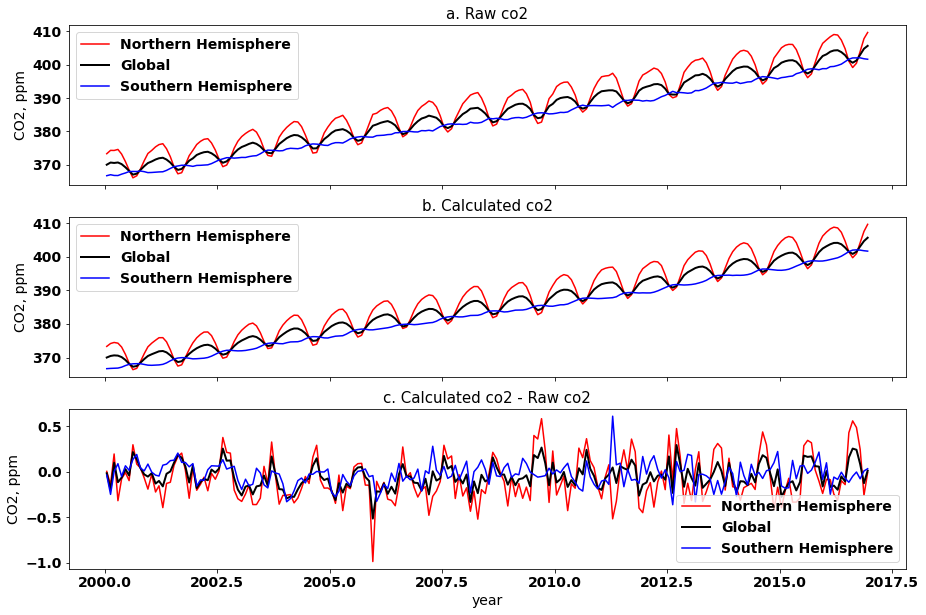

In [8]:
x_decimalyear = decimalDate_datetime(pd.to_datetime(pd.DataFrame(global_co2_raw.index)[0],format='%Y-%m-%d'))
fig,axis = plt.subplots(nrows=3,ncols=1,sharex=True, sharey=False, figsize = (15,10))
(ax1,ax2,ax3) = axis

ax1.plot(x_decimalyear,NH_co2_raw, 'r', label = "Northern Hemisphere")
ax1.plot(x_decimalyear,global_co2_raw, 'k', label = "Global", lw=2)
ax1.plot(x_decimalyear,SH_co2_raw,'b', label = "Southern Hemisphere")
ax1.set_ylabel("CO2, ppm")
ax1.legend()
ax1.set_title("a. Raw co2",fontsize=15)

ax2.plot(x_decimalyear,NH_co2_cal, 'r', label = "Northern Hemisphere")
ax2.plot(x_decimalyear,global_co2_cal, 'k', label = "Global", lw=2)
ax2.plot(x_decimalyear,SH_co2_cal,'b', label = "Southern Hemisphere")
ax2.set_ylabel("CO2, ppm")
ax2.legend()
ax2.set_title("b. Calculated co2",fontsize=15)

ax3.plot(x_decimalyear,NH_co2_cal - NH_co2_raw, 'r', label = "Northern Hemisphere")
ax3.plot(x_decimalyear,global_co2_cal - global_co2_raw, 'k', label = "Global", lw=2)
ax3.plot(x_decimalyear,SH_co2_cal - SH_co2_raw,'b', label = "Southern Hemisphere")
ax3.set_xlabel("year")
ax3.set_ylabel("CO2, ppm")
ax3.legend()
ax3.set_title("c. Calculated co2 - Raw co2",fontsize=15);

plt.savefig("figure4.png")

# Plot co2 zonal map 

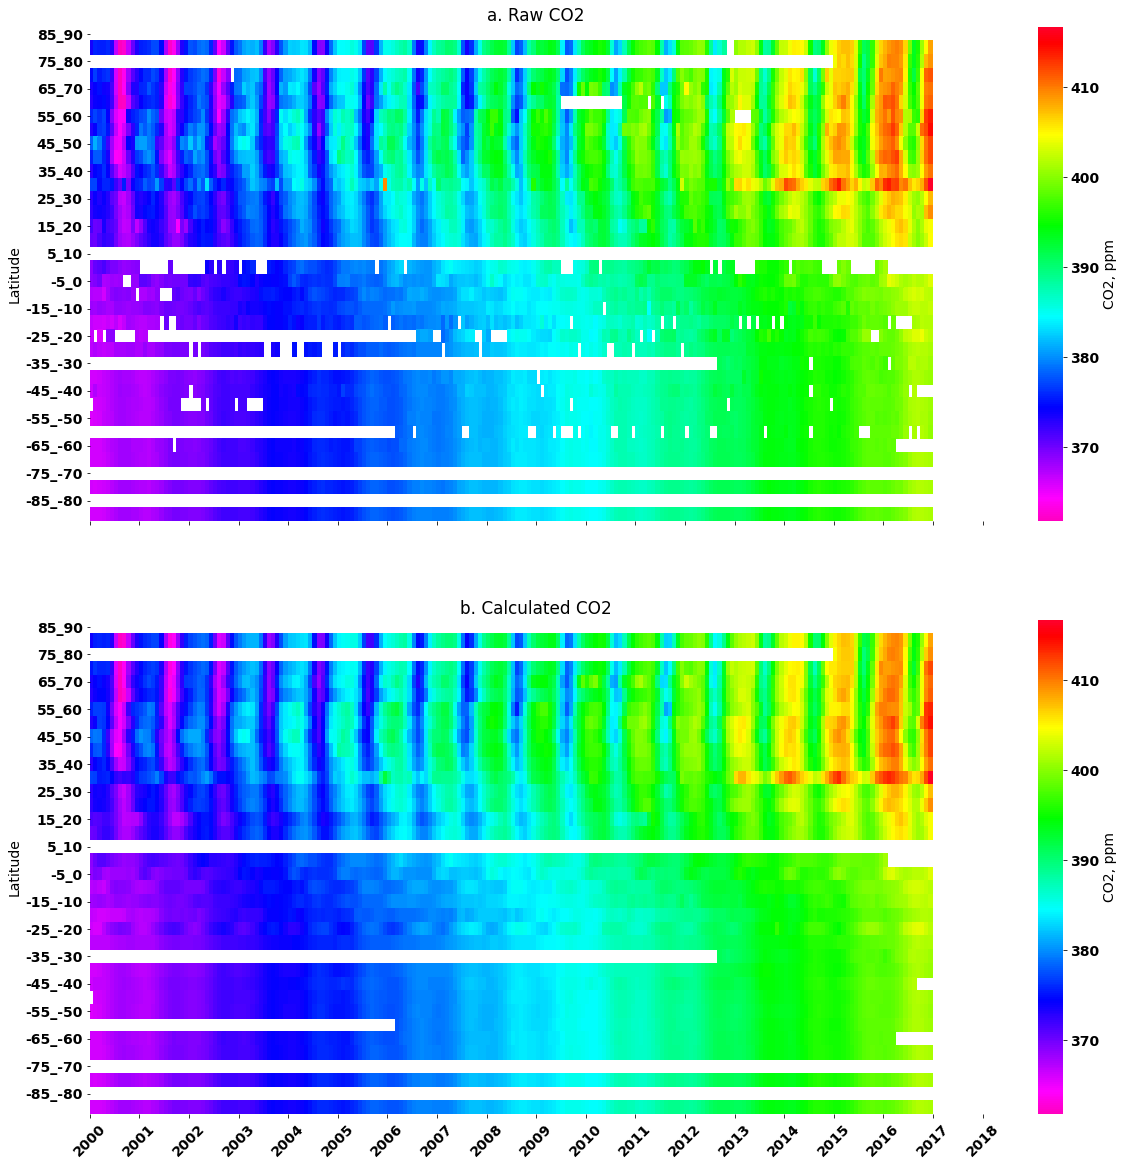

In [9]:
# Arrange dataframe for plot
df_co2_raw = pd.read_csv(IN_PATH + "df_co2_raw_ctracker_obs.csv")
df_co2_cal = pd.read_csv(IN_PATH + "df_co2_cal_ctracker_obs.csv")

zonal_deg = 5

lat_range = range(-90,90,zonal_deg)

df_zonal_raw = pd.DataFrame()
df_zonal_cal = pd.DataFrame() 
for i in lat_range:

    lat_id = (i < df_co2_raw.lat) & (df_co2_raw.lat<= i+zonal_deg)
    temp_raw = df_co2_raw.loc[lat_id,:]
    temp_cal = df_co2_cal.loc[lat_id,:]
    
    df_zonal_raw = pd.concat([df_zonal_raw,  pd.DataFrame(temp_raw.iloc[:,4:].mean()).T] )
    df_zonal_cal = pd.concat([df_zonal_cal,  pd.DataFrame(temp_cal.iloc[:,4:].mean()).T] )

df_zonal_raw["lat"] = [str(i) + "_" + str(i+zonal_deg)  for i in lat_range]
df_zonal_cal["lat"] = [str(i) + "_" + str(i+zonal_deg)  for i in lat_range]
cols_new = df_zonal_raw.columns.to_list()
cols_new = cols_new[-1:] + cols_new[:-1]
df_zonal_raw = df_zonal_raw.loc[:,cols_new]
df_zonal_cal = df_zonal_cal.loc[:,cols_new]
df_zonal_raw = df_zonal_raw.iloc[::-1] 
df_zonal_cal = df_zonal_cal.iloc[::-1] 
df_zonal_raw = df_zonal_raw.set_index(["lat"])
df_zonal_cal = df_zonal_cal.set_index(["lat"])

# plot
xticks = [i for i in range(0, df_zonal_raw.shape[1]+12, 12)]
xticklabels = [i for i in range(2000,2019)]

cmax = max(df_zonal_cal.max().max(), df_zonal_raw.max().max())
cmin = max(df_zonal_cal.min().min(), df_zonal_raw.min().min())

# sns.set(font_scale=1.4)

fig,axis = plt.subplots(nrows=2,ncols=1,sharex=True,sharey=True,figsize=[20,20])
(ax1,ax2) = axis
sns.heatmap(df_zonal_raw, cmap=plt.get_cmap("gist_rainbow_r"), ax=ax1, cbar_kws={'label': 'CO2, ppm'}, vmax=cmax,vmin=cmin)
ax1.set_ylabel("Latitude")
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticklabels,rotation=45)
ax1.set_title("a. Raw CO2")

sns.heatmap(df_zonal_cal, cmap=plt.get_cmap("gist_rainbow_r"), ax=ax2, cbar_kws={'label': 'CO2, ppm'}, vmax=cmax,vmin=cmin)
ax2.set_ylabel("Latitude")
ax2.set_xticks(xticks) 
ax2.set_xticklabels(xticklabels,rotation=45)
ax2.set_title("b. Calculated CO2");

plt.savefig("figure5.png")

# Calculate zonal and global CO2 growth rate average over each 30 degree latitudinal band

In [10]:
df_co2rate_cal = pd.read_csv(IN_PATH + "df_co2rate_cal_ctracker_obs.csv")

zonal_deg = 30
df_area = pd.DataFrame(grid_area(0.5))
area_lat = df_area.iloc[:,0]
area_zonal = area_lat.groupby(np.arange(len(area_lat))//(zonal_deg/0.5)).sum()

global_weight = area_zonal/area_zonal.sum()
NH_weight = area_zonal[:len(area_zonal)/2-1] /(area_zonal.sum()/2)
SH_weight = area_zonal[len(area_zonal)/2:] /(area_zonal.sum()/2)

lat_range = range(-90,90,zonal_deg)

df_zonal_cal = pd.DataFrame() 
for i in lat_range:
    lat_id = (i < df_co2_raw.lat) & (df_co2_raw.lat<= i+zonal_deg)
    temp_cal = df_co2rate_cal.loc[lat_id,:]
    
    df_zonal_cal = pd.concat([df_zonal_cal,  pd.DataFrame(temp_cal.iloc[:,4:].mean()).T] )

df_zonal_cal["lat"] = [str(i) + "_" + str(i+zonal_deg)  for i in lat_range]
cols_new = df_zonal_cal.columns.to_list()
cols_new = cols_new[-1:] + cols_new[:-1]
df_zonal_cal = df_zonal_cal.loc[:,cols_new]
df_zonal_cal = df_zonal_cal.iloc[::-1] 
df_zonal_cal = df_zonal_cal.set_index(["lat"])

global_weight = global_weight.set_axis(df_zonal_cal.index)
NH_weight = NH_weight.set_axis(df_zonal_cal.index[:3])
SH_weight = SH_weight.set_axis(df_zonal_cal.index[3:])

# calculated global weighted average
global_co2rate_cal = df_zonal_cal.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2rate_cal = df_zonal_cal.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2rate_cal = df_zonal_cal.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

# calculate annual co2
datetime = pd.to_datetime(pd.DataFrame(global_co2rate_cal.index)[0],format='%Y-%m-%d')
co2rate_annual = pd.concat([global_co2rate_cal,NH_co2rate_cal,SH_co2rate_cal],axis=1)
co2rate_annual.columns = ["global_co2rate_cal","NH_co2rate_cal","SH_co2rate_cal"]
co2rate_annual["year"] = datetime.dt.year.tolist()
co2rate_annual.groupby(["year"]).mean().T

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
global_co2rate_cal,1.336033,1.651802,2.385119,2.395848,1.594668,2.430481,1.735877,2.115530,1.516668,1.723946,2.352683,1.688446,2.621152,2.435243,1.724292,2.666842,3.084801,NaN
NH_co2rate_cal,1.461418,1.459890,2.486241,2.596321,1.363035,2.685902,1.820325,2.020906,1.464193,1.764272,2.661606,1.618188,2.650480,2.384188,1.749847,2.526567,3.221206,NaN
SH_co2rate_cal,1.210647,1.843714,2.283997,2.195375,1.826302,2.175060,1.651429,2.210154,1.569143,1.683621,2.043760,1.758705,2.591824,2.486297,1.698738,2.807116,2.948396,NaN


# Plot global, NH and SH area-weighted average CO2 growth rate

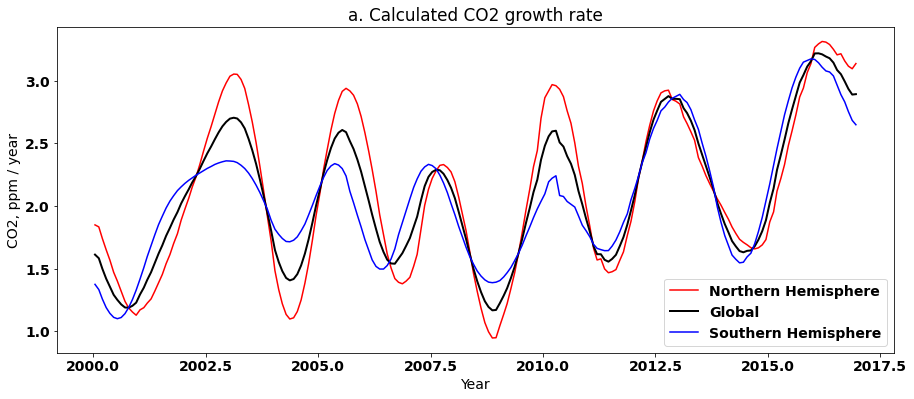

In [11]:
x_decimalyear = decimalDate_datetime(pd.to_datetime(pd.DataFrame(global_co2rate_cal.index)[0],format='%Y-%m-%d'))

fig = plt.figure( figsize = (15,6))
ax = plt.axes()

ax.plot(x_decimalyear,NH_co2rate_cal, 'r', label = "Northern Hemisphere")
ax.plot(x_decimalyear,global_co2rate_cal, 'k', label = "Global", lw=2)
ax.plot(x_decimalyear,SH_co2rate_cal,'b', label = "Southern Hemisphere")
ax.set_xlabel("Year")
ax.set_ylabel("CO2, ppm / year")
ax.legend()
ax.set_title("a. Calculated CO2 growth rate");

plt.savefig("figure6.png")

# Plot CO2 growth rate  zonal map

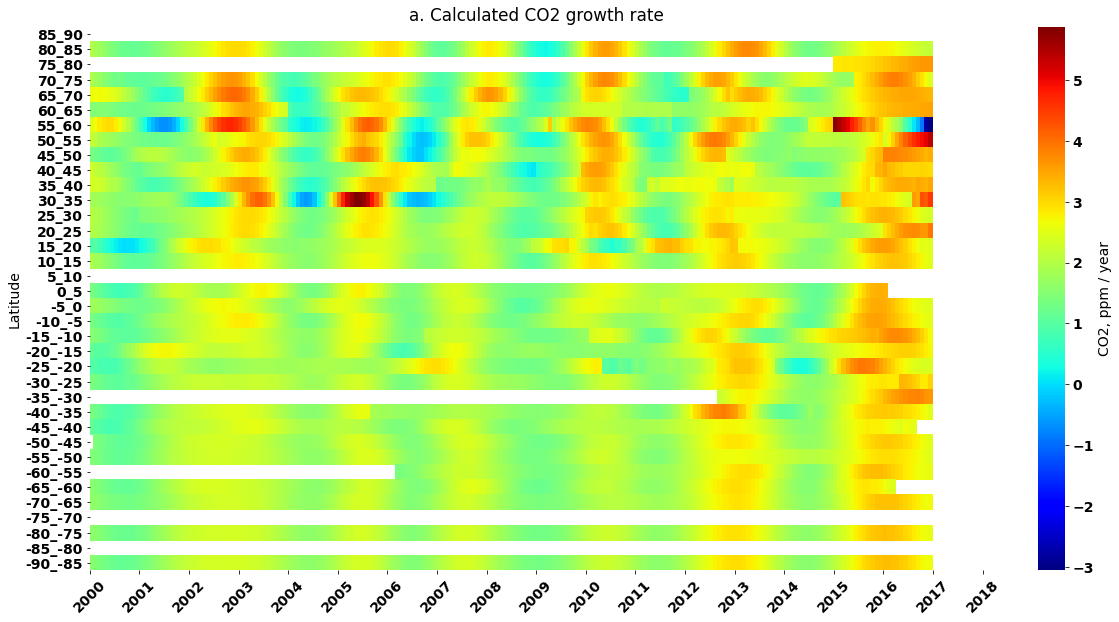

In [12]:
# Arrange dataframe for plot
df_co2rate_cal = pd.read_csv(IN_PATH + "df_co2rate_cal_ctracker_obs.csv")

zonal_deg = 5
lat_range = range(-90,90,zonal_deg)
df_zonal_cal = pd.DataFrame() 

for i in lat_range:
    lat_id = (i < df_co2rate_cal.lat) & (df_co2rate_cal.lat<= i+zonal_deg)
    temp_cal = df_co2rate_cal.loc[lat_id,:]
    df_zonal_cal = pd.concat([df_zonal_cal,  pd.DataFrame(temp_cal.iloc[:,4:].mean()).T] )

df_zonal_cal["lat"] = [str(i) + "_" + str(i+zonal_deg)  for i in lat_range]
cols_new = df_zonal_cal.columns.to_list()
cols_new = cols_new[-1:] + cols_new[:-1]
df_zonal_cal = df_zonal_cal.loc[:,cols_new]
df_zonal_cal = df_zonal_cal.iloc[::-1] 
df_zonal_cal = df_zonal_cal.set_index(["lat"])

# plot
xticks = [i for i in range(0, df_zonal_cal.shape[1]+12, 12)]
xticklabels = [i for i in range(2000,2019)]

# sns.set(font_scale=1.4)
fig = plt.figure(figsize=[20,10])
# ax1 = plt.axis()
g = sns.heatmap(df_zonal_cal, cmap=plt.get_cmap("jet"), cbar_kws={'label': 'CO2, ppm / year'})
g.set_ylabel("Latitude")
g.set_xticks(xticks)
g.set_xticklabels(xticklabels,rotation=45) 
g.set_title("a. Calculated CO2 growth rate");


#BIR statation at (8.3, 58)